In [63]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

from scipy.stats import norm
from dateutil import relativedelta
from pykrx import stock

In [64]:
def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def gamma (option_type, S, K, r, T, sigma):

    d1 = (np.log(S/K) + (r + 0.5 * (sigma ** 2)) * T ) / (sigma * np.sqrt(T))

    return stats.norm.pdf(d1) / (sigma * S * np.sqrt(T))

def new_next_exp(today):

    today = dt.datetime.strptime(today, '%Y-%m-%d')

    next_mon = today + relativedelta.relativedelta(months=1)
    nnext_mon = next_mon + relativedelta.relativedelta(months=1)

    if today.day < 15:
        result = next_mon
    else:
        result = nnext_mon
        
    return result.strftime("%Y%m")

def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    date = new_next_exp(date)
    base_date = dt.datetime.strptime(date, '%Y%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

def tau_creator (today, date):
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    
    return (date - today).days/252

def tau_arr_creator (today, date):

    days = tau_creator(today, date) * 252
    
    return (np.flip(np.arange(0, days+1)) * 1/252).reshape(-1,1)

def delta_cal (s, k, r, q, vol, t):

    def d1_cal (s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))
        
    return norm.cdf(d1_cal(s, k, r, q, vol, t))




In [3]:
file_path = os.getcwd() + '/Data/'

kospi200 = stock.get_index_ohlcv('20050801', '20221130', '1028')['종가']
kospi200_vol = pd.DataFrame(np.log(kospi200).diff().rolling(60).std() * np.sqrt(252)).dropna()
kospi200_vol.index = pd.to_datetime(kospi200_vol.index)
rf = pd.read_csv(file_path + 'rf.csv', index_col=['Date'], parse_dates=True)


In [4]:
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'kospi200/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'kospi200/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'kospi200/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'kospi200/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'kospi200/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'kospi200/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_open.pkl')


data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    '''코스피 아닐경우 바로 아래만 진행'''

    k_list = [x[7:] for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df


cpflag          C                                                          \
tick       200709                                                           
strike      165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike      187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     475.0  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

In [5]:
def atm_mapping (df, s0):
    '''Option MultiIndex df with spot price'''
    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    atm_k = k_arr[np.where((s0 - k_arr)>0)][-1]

    return atm_k

def otm_mapping (df, s0, mul):

    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    otm_k = k_arr[np.where((s0 * (1 + mul) - k_arr)>0)][-1]

    return otm_k


코스피 200의 거래승수인 250000을 고려

In [87]:
'''거래 승수 (만 단위)'''
mul = 25

'''Time 관련'''

date    = '2007-11-01'
exdate  = new_next_exp(date)
ex_date = option_date_creator(1, date)
#t       = tau_creator(date, ex_date)
#t_arr   = tau_arr_creator(date, ex_date)

'''포지션 비율'''

long_num = 1
short_num = -2

'''투자 Horizon'''

i_horizon   = len(kospi200.loc[date:ex_date])
tau_arr     = (np.flip(np.arange(0, i_horizon)) * 1/252).reshape(-1,1)
tau         = tau_arr[0].item()

'''Input Params'''

s0      = kospi200.loc[date]
s0_arr  = kospi200.loc[date:ex_date].to_numpy().reshape(-1,1)
s0_vol  = kospi200_vol.loc[date].values[0]
s0_vol_arr  = kospi200_vol.loc[date:ex_date].to_numpy().reshape(-1,1)
r       = rf.loc[date].values[0]

test        = pd.DataFrame(df.loc[date, ('C', exdate, slice(None), slice(None))]).T
atm_k       = atm_mapping(test, s0 - 40) 
otm_k       = otm_mapping(test, s0, 0.2) 
op_pr_atm   = df.loc[date, ('C', exdate, str(atm_k), ['종가'])].values[0]
op_pr_otm   = df.loc[date, ('C', exdate, str(otm_k), ['종가'])].values[0]
iv          = df.loc[date, ('C', exdate, str(otm_k), ['내재변동성'])].values[0]

'''Cost들'''

init_cost = op_pr_otm * short_num + op_pr_atm * long_num

print(s0_vol)
pd.DataFrame(df.loc[date, ('C', exdate, [str(atm_k), str(otm_k)], slice(None))])

init_df = pd.DataFrame(df.loc[date, ('C', exdate, [str(atm_k), str(otm_k)], slice(None))]).T.loc[:,(slice(None), slice(None), slice(None), ['종가'])]



0.308756163299606


어떠한 그래프를 만들것이냐?

In [88]:
init_df = pd.DataFrame(df.loc[date, ('P', exdate, [str(atm_k), str(otm_k)], slice(None))]).T.loc[:,(slice(None), slice(None), slice(None), ['종가'])]

init_df

cpflag          P       
tick       200712       
strike      220.0  277.5
feature        종가     종가
2007-11-01   1.25  20.95

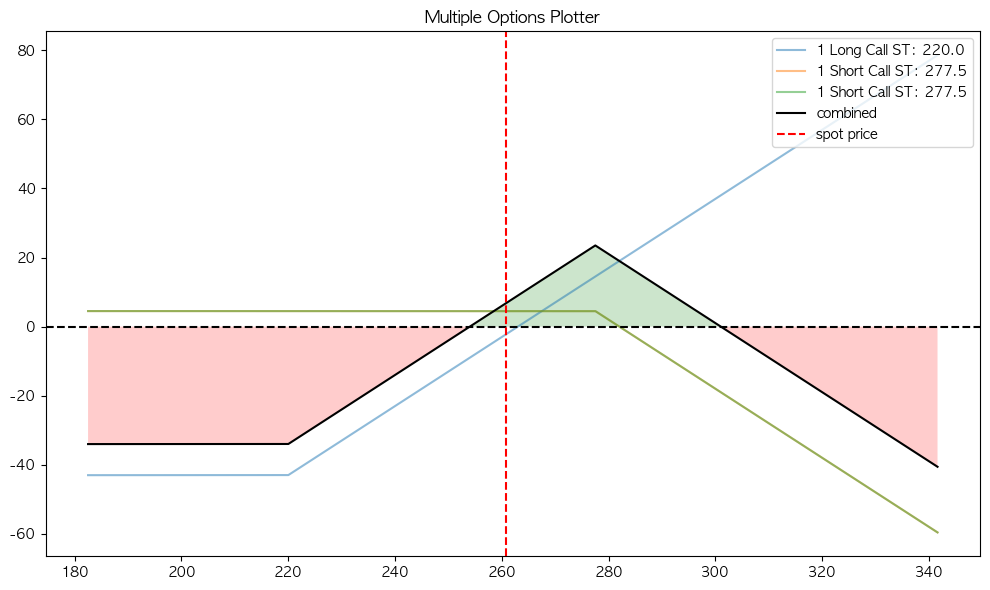

In [91]:
import opstrat as op

#op.single_plotter(spot=s0, strike=atm_k, op_type='c', tr_type='s', op_pr=op_pr_atm)

op_1 = {'op_type':'c', 'strike':atm_k, 'tr_type':'b', 'op_pr':op_pr_atm}
op_2 = {'op_type':'c', 'strike':otm_k, 'tr_type':'s', 'op_pr':op_pr_otm}

#op_1 = {'op_type':'c', 'strike':atm_k, 'tr_type':'b', 'op_pr':0}
#op_1 = {'op_type':'c', 'strike':atm_k, 'tr_type':'b', 'op_pr':0}

op_list = [op_1, op_2, op_2]

op.multi_plotter(spot=s0, spot_range=30, op_list=op_list)

In [92]:
init_cost * mul

850.0

이니셜 217.5만원

In [93]:
def path_changes (path_1):
    '''calculate path's changes'''

    return np.vstack([path_1[0], path_1[1:] - path_1[:-1]])

def create_hedging_df (s0_arr, atm_k, otm_k, r, q, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200):

    st_delta_path = \
    np.round(delta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr) * long_num * 1 + \
             delta_cal(s0_arr, otm_k, r, 0, s0_vol, tau_arr) * short_num * -1, 3)

    st_delta_path = pd.DataFrame(st_delta_path, columns=['Delta'])
    st_delta_path.index = kospi200.loc[date:ex_date].index

    st_delta_path['Delta_ch'] = path_changes(st_delta_path.to_numpy())

    st_delta_path['spot_price(Close)'] = s0_arr


    st_delta_path['Cost_ch'] = st_delta_path[['Delta_ch']] * s0_arr

    st_delta_path['Cum_cost'] = st_delta_path['Cost_ch'].cumsum()

    st_delta_path['Hist_vol'] = s0_vol_arr

    return st_delta_path

create_hedging_df(s0_arr, atm_k, otm_k, r, 0, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200)

,Delta,Delta_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,
2007-11-01,1.594,1.594,260.76,415.65144,415.65144,0.308756
2007-11-02,1.415,-0.179,254.74,-45.59846,370.05298,0.312097
2007-11-05,1.384,-0.031,253.91,-7.87121,362.18177,0.310897
2007-11-06,1.530,0.146,259.24,37.84904,400.03081,0.313427
2007-11-07,1.507,-0.023,258.74,-5.95102,394.07979,0.310186
2007-11-08,1.253,-0.254,249.97,-63.49238,330.58741,0.318645
2007-11-09,1.305,0.052,252.21,13.11492,343.70233,0.305322
2007-11-12,1.085,-0.220,243.89,-53.65580,290.04653,0.312504
2007-11-13,1.097,0.012,244.73,2.93676,292.98329,0.310878


배당은 0으로 가정해보자

In [33]:
'''Long Delta'''
delta_cal(s0, atm_k, r, 0, s0_vol, tau) * long_num * 1

0.5906896646155299

In [34]:
'''short Delta'''
delta_cal(s0, otm_k, r, 0, s0_vol, tau) * short_num * -1

0.06791389106307656

In [35]:
'''position Delta'''
delta_cal(s0, atm_k, r, 0, s0_vol, tau) * long_num * 1 + \
    delta_cal(s0, otm_k, r, 0, s0_vol, tau) * short_num * -1

0.6586035556786064

포지션의 델타를 그려보자

콜옵션의 델타는 매도, 풋옵션의 델타는 매수이다.

따라서 콜옵션 매도시 델타는 매수, 풋옵션 매도시 델타는 매도이다.

In [36]:
def path_changes (path_1):
    '''calculate path's changes'''

    return np.vstack([path_1[0], path_1[1:] - path_1[:-1]])

콜 매도 > 현물 매수로 델타 중립 <br>
콜 매수 > 현물 매도로 델타 중립

In [37]:
def path_changes (path_1):
    '''calculate path's changes'''

    return np.vstack([path_1[0], path_1[1:] - path_1[:-1]])

def create_hedging_df (s0_arr, atm_k, otm_k, r, q, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200):

    st_delta_path = \
    np.round(delta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr) * long_num * 1 + \
             delta_cal(s0_arr, otm_k, r, 0, s0_vol, tau_arr) * short_num * -1, 3)

    st_delta_path = pd.DataFrame(st_delta_path, columns=['Delta'])
    st_delta_path.index = kospi200.loc[date:ex_date].index

    st_delta_path['Delta_ch'] = path_changes(st_delta_path.to_numpy())

    st_delta_path['spot_price(Close)'] = s0_arr


    st_delta_path['Cost_ch'] = st_delta_path[['Delta_ch']] * s0_arr

    st_delta_path['Cum_cost'] = st_delta_path['Cost_ch'].cumsum()

    st_delta_path['Hist_vol'] = s0_vol_arr

    return st_delta_path

create_hedging_df(s0_arr, atm_k, otm_k, r, 0, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200)

,Delta,Delta_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,
2007-08-01,0.659,0.659,234.36,154.44324,154.44324,0.210903
2007-08-02,0.637,-0.022,233.84,-5.14448,149.29876,0.210549
2007-08-03,0.730,0.093,236.91,22.03263,171.33139,0.211616
2007-08-06,0.630,-0.100,233.92,-23.39200,147.93939,0.213753
2007-08-07,0.643,0.013,234.50,3.04850,150.98789,0.213734
2007-08-08,0.820,0.177,240.07,42.49239,193.48028,0.218138
2007-08-09,0.846,0.026,241.00,6.26600,199.74628,0.218132
2007-08-10,0.511,-0.335,230.68,-77.27780,122.46848,0.236640
2007-08-13,0.606,0.095,233.88,22.21860,144.68708,0.237667


In [15]:
atm_k

232.5

In [38]:
create_hedging_df(s0_arr, atm_k, otm_k, r, 0, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200)

,Delta,Delta_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,
2007-08-01,0.659,0.659,234.36,154.44324,154.44324,0.210903
2007-08-02,0.637,-0.022,233.84,-5.14448,149.29876,0.210549
2007-08-03,0.730,0.093,236.91,22.03263,171.33139,0.211616
2007-08-06,0.630,-0.100,233.92,-23.39200,147.93939,0.213753
2007-08-07,0.643,0.013,234.50,3.04850,150.98789,0.213734
2007-08-08,0.820,0.177,240.07,42.49239,193.48028,0.218138
2007-08-09,0.846,0.026,241.00,6.26600,199.74628,0.218132
2007-08-10,0.511,-0.335,230.68,-77.27780,122.46848,0.236640
2007-08-13,0.606,0.095,233.88,22.21860,144.68708,0.237667


In [69]:
'''position Delta'''
st_delta_path = \
    np.round(delta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr) * long_num * 1 + \
             delta_cal(s0_arr, otm_k, r, 0, s0_vol, tau_arr) * short_num * -1, 3)

st_delta_path = pd.DataFrame(st_delta_path, columns=['Delta'])
st_delta_path.index = kospi200.loc[date:ex_date].index

st_delta_path['Delta_ch'] = path_changes(st_delta_path.to_numpy())

st_delta_path['spot_price(Close)'] = s0_arr


st_delta_path['Cost_ch'] = st_delta_path[['Delta_ch']] * s0_arr

st_delta_path['Cum_cost'] = st_delta_path['Cost_ch'].cumsum()

st_delta_path['Hist_vol'] = s0_vol_arr

st_delta_path

,Delta,Delta_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,
2007-08-01,0.659,0.659,234.36,154.44324,154.44324,0.210903
2007-08-02,0.637,-0.022,233.84,-5.14448,149.29876,0.210549
2007-08-03,0.730,0.093,236.91,22.03263,171.33139,0.211616
2007-08-06,0.630,-0.100,233.92,-23.39200,147.93939,0.213753
2007-08-07,0.643,0.013,234.50,3.04850,150.98789,0.213734
2007-08-08,0.820,0.177,240.07,42.49239,193.48028,0.218138
2007-08-09,0.846,0.026,241.00,6.26600,199.74628,0.218132
2007-08-10,0.511,-0.335,230.68,-77.27780,122.46848,0.236640
2007-08-13,0.606,0.095,233.88,22.21860,144.68708,0.237667


In [59]:
'''position Delta'''
st_delta_path = \
    np.round(delta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr) * long_num * 1, 3) \
             #delta_cal(s0_arr, otm_k, r, 0, s0_vol, tau_arr) * short_num * -1, 3)

st_delta_path = pd.DataFrame(st_delta_path, columns=['Delta'])
st_delta_path.index = kospi200.loc[date:ex_date].index

st_delta_path['Delta_ch'] = path_changes(st_delta_path.to_numpy())

st_delta_path['spot_price(Close)'] = s0_arr


st_delta_path['Cost_ch'] = st_delta_path[['Delta_ch']] * s0_arr

st_delta_path['Cum_cost'] = st_delta_path['Cost_ch'].cumsum()

st_delta_path['Hist_vol'] = s0_vol_arr

st_delta_path

,Delta,Delta_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,
2007-08-01,0.591,0.591,234.36,138.50676,138.50676,0.210903
2007-08-02,0.579,-0.012,233.84,-2.80608,135.70068,0.210549
2007-08-03,0.649,0.070,236.91,16.58370,152.28438,0.211616
2007-08-06,0.580,-0.069,233.92,-16.14048,136.14390,0.213753
2007-08-07,0.594,0.014,234.50,3.28300,139.42690,0.213734
2007-08-08,0.723,0.129,240.07,30.96903,170.39593,0.218138
2007-08-09,0.745,0.022,241.00,5.30200,175.69793,0.218132
2007-08-10,0.493,-0.252,230.68,-58.13136,117.56657,0.236640
2007-08-13,0.578,0.085,233.88,19.87980,137.44637,0.237667


In [62]:
'''position Delta'''
st_delta_path = \
    np.round(#delta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr) * long_num * 1) \
             delta_cal(s0_arr, otm_k, r, 0, s0_vol, tau_arr) * short_num * -1, 3)

st_delta_path = pd.DataFrame(st_delta_path, columns=['Delta'])
st_delta_path.index = kospi200.loc[date:ex_date].index

st_delta_path['Delta_ch'] = path_changes(st_delta_path.to_numpy())

st_delta_path['spot_price(Close)'] = s0_arr


st_delta_path['Cost_ch'] = st_delta_path[['Delta_ch']] * s0_arr

st_delta_path['Cum_cost'] = st_delta_path['Cost_ch'].cumsum()

st_delta_path['Hist_vol'] = s0_vol_arr

st_delta_path

,Delta,Delta_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,
2007-08-01,0.068,0.068,234.36,15.93648,15.93648,0.210903
2007-08-02,0.059,-0.009,233.84,-2.10456,13.83192,0.210549
2007-08-03,0.081,0.022,236.91,5.21202,19.04394,0.211616
2007-08-06,0.050,-0.031,233.92,-7.25152,11.79242,0.213753
2007-08-07,0.049,-0.001,234.50,-0.23450,11.55792,0.213734
2007-08-08,0.097,0.048,240.07,11.52336,23.08128,0.218138
2007-08-09,0.101,0.004,241.00,0.96400,24.04528,0.218132
2007-08-10,0.018,-0.083,230.68,-19.14644,4.89884,0.236640
2007-08-13,0.028,0.010,233.88,2.33880,7.23764,0.237667


In [ ]:
(st_delta_path * 250000).iloc[-1,-1] - init_cost * 250000

1677762.1117806383

In [20]:
import matplotlib.pyplot as plt

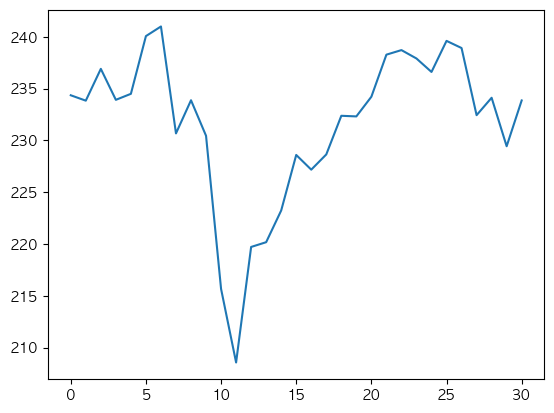

In [40]:
plt.plot(s0_arr)

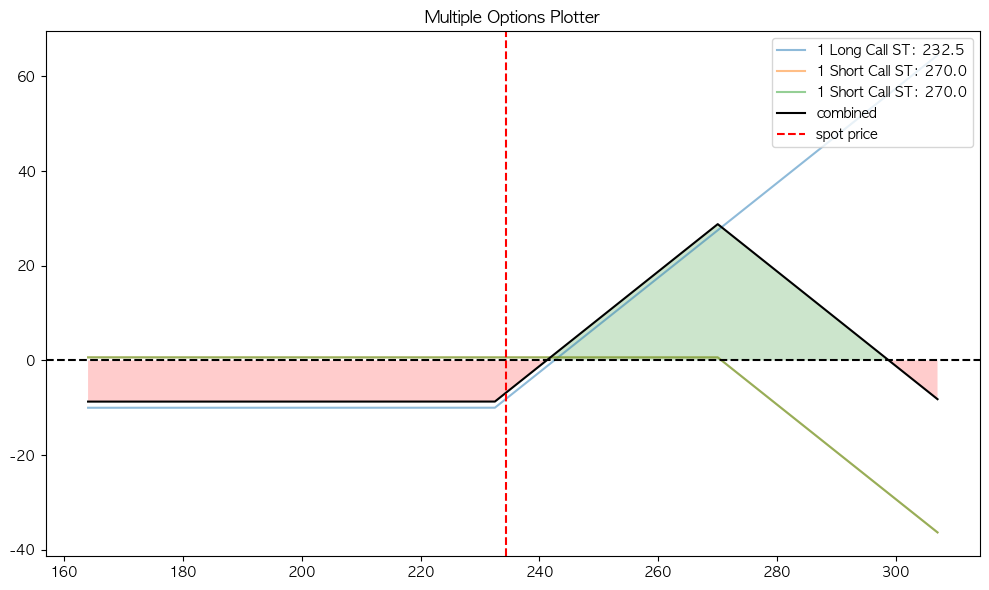

In [42]:
import opstrat as op

#op.single_plotter(spot=s0, strike=atm_k, op_type='c', tr_type='s', op_pr=op_pr_atm)

op_1 = {'op_type':'c', 'strike':atm_k, 'tr_type':'b', 'op_pr':op_pr_atm}
op_2 = {'op_type':'c', 'strike':otm_k, 'tr_type':'s', 'op_pr':op_pr_otm}

op_list = [op_1, op_2, op_2]

op.multi_plotter(spot=s0, spot_range=30, op_list=op_list)

In [44]:
s0_arr

array([[234.36],
       [233.84],
       [236.91],
       [233.92],
       [234.5 ],
       [240.07],
       [241.  ],
       [230.68],
       [233.88],
       [230.45],
       [215.67],
       [208.57],
       [219.72],
       [220.18],
       [223.24],
       [228.6 ],
       [227.18],
       [228.65],
       [232.38],
       [232.32],
       [234.22],
       [238.28],
       [238.72],
       [237.91],
       [236.61],
       [239.61],
       [238.92],
       [232.44],
       [234.12],
       [229.44],
       [233.86]])

In [58]:
-9.35 * mul

-233.75

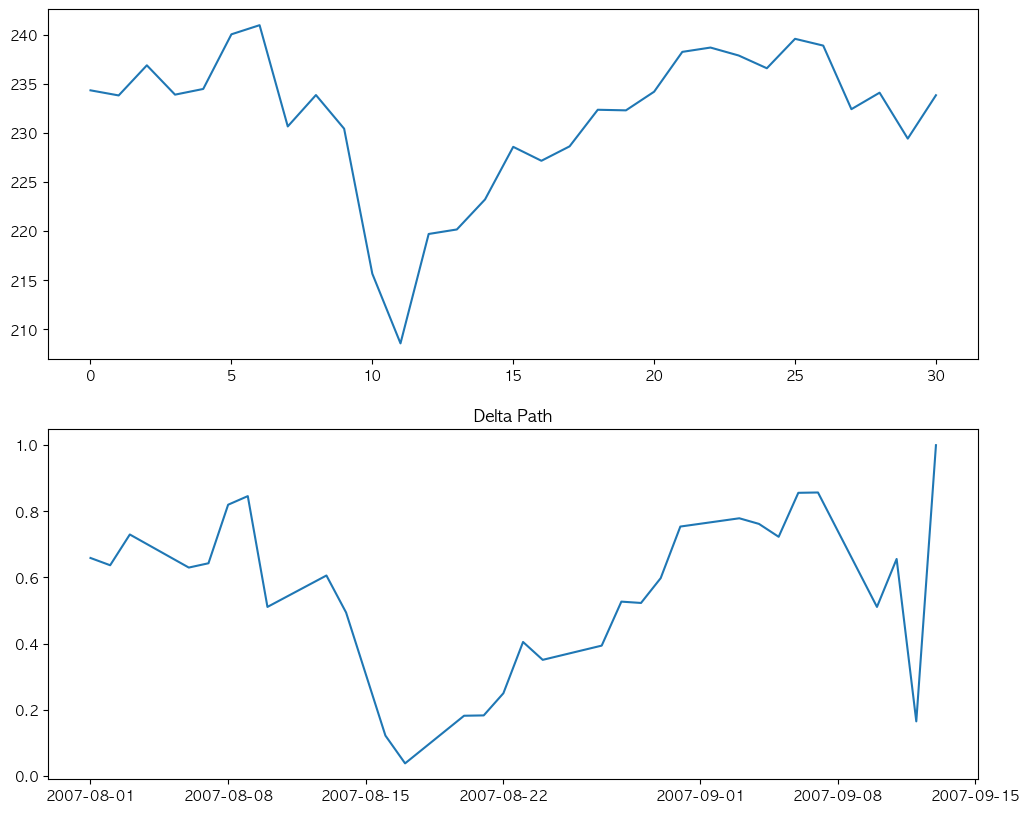

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.plot(s0_arr)

plt.subplot(2,1,2)
plt.title('Delta Path')
plt.plot(pd.DataFrame(st_delta_path['Delta']))